# Installing and Importing Libraries

In [ ]:
# Installations
import sys
if 'google.colab' in sys.modules:
    !pip install emoji --upgrade
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !python -m spacy download en_core_web_lg
    !pip install pyldavis
    !pip install gensim
    !pip install chart_studio
    !pip install --upgrade autopep8
    !pip install tweepy==4.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=647be1a9877659c2067cec51495274eefed9657fe0a6e4c18fc9656f5b9542d2
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Required Libraries

#Base and Cleaning 
import tweepy
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


# Functions


In [ ]:
#Removes emojis and url's from tweets
def clean_tweet(text):
    emoji_free_text= emoji.replace_emoji(text, '')
    clean_text = re.sub(r'http\S+', '', emoji_free_text)
    return clean_text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Performs lemmatization in a text
def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Tokenizer function
def tokenize(text):

    text = re.sub('[^a-zA-Z 0-9]', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub('@!$', '', text) # Remove @ ! $

    tokens = text.lower().split() # Make text lowercase and split it

    return tokens

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Defining a function to loop over number of topics to be used to find an  optimal number of topics via coherence value
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Gets the contribution score for each tweet according to its most relevant topic
def format_topics_sentences(ldamodel, corpus, tweets):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(tweets)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Data Gathering

In [ ]:
#Twitter Keys

consumer_key = '0U8DU7xm6LokJIY7NVsxof2iN'
consumer_secret = 'laooGyUhS0qtRDySqeTXPQBZPFETxRZHAkZYCiggl4aChr0jrI'
access_token = '1494139415911931904-nbBK8CVScmPJGwLVQASzYBjbFBXBPs'
access_token_secret = 'KSM1PSpvYAqjzV2AsYKa4dqSGGWDtr51SYorfED5f5Hnz'
bearer_token="AAAAAAAAAAAAAAAAAAAAAJ6ClgEAAAAA25Q%2FW0u3vVZf9dxt7vfyQcFMKw8%3DbFwfWjWXcBQ4tovioM4zCuxBrX1KjPGtcKi8iwlCJY9OevSmc6"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Initializing the Twitter client
client = tweepy.Client(
    bearer_token=bearer_token,
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    return_type = requests,
    wait_on_rate_limit=True
)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Twitter handle of the subject of our tweet topic modeling
user_twitter_name = 'elonmusk'

# Fetch user data
user = client.get_user(username=user_twitter_name)

# Extract the user id and user name
user_id = user.data.id

# Fetch tweets by the user 
tweets = client.get_users_tweets(id = user_id, max_results=100)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Initializing the Dataframe to store the tweets
tweets_df = pd.DataFrame(columns=['original_tweet'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Cleansing

In [ ]:
# Adding the tweets text to the dataframe
tweets_text = []
for tweet in tweets.data:
  tweets_text.append(tweet.text)

tweets_df['original_tweet'] = tweets_text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Cleaning the text from emojis and url's and appending it to a new column
tweets_df['clean_tweet'] = tweets_df['original_tweet'].apply(clean_tweet)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Pre-processing

In [ ]:
#Loading Spacy
nlp = spacy.load('en_core_web_lg')

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)

tokens = []

for doc in tokenizer.pipe(tweets_df['clean_tweet'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
tweets_df['tokens'] = tokens

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Make tokens a string again and lemmatize the string
token_strings = [' '.join(map(str, l)) for l in tweets_df['tokens']]
lemmas = []

for text in token_strings:
   lemmas.append(get_lemmas(text))

tweets_df['lemmas'] = lemmas

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Make lemmatizations a string again and clean the words to get the final tokens
lemmas_strings = [' '.join(map(str, l)) for l in tweets_df['lemmas']]
                 
final_tokens = []

for text in lemmas_strings:
   final_tokens.append(tokenize(text))

tweets_df['final_tokens'] = final_tokens

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

In [ ]:
# Create a id2word dictionary
id2word = Dictionary(tweets_df['final_tokens'])
print(len(id2word))

528


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

103


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in tweets_df['final_tokens']]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, workers=12, passes=5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
twitter say timsweeneyepic old amp heavy titterdaily rt year ago

------ Topic 1 ------
actually yeah know matter company davidasinclair think great wallstreetsilv bbc

------ Topic 2 ------
influence iamharaldur bbc fund davidmweissman pay principle need lol think

------ Topic 3 ------
press think drug legacy public scottadamssays kanekoathegreat crime micsolana yes

------ Topic 4 ------
people right good actually question let criminal time sf micsolana

------ Topic 5 ------
probably wallstreetsilv year wow scottadamssays 10 lack live problem try

------ Topic 6 ------
tesla talent wrong amp heavy paulg industry yeah end rapidly

------ Topic 7 ------
amp jonerlichman day billym2k titterdaily dogeofficialceo true cbdoge buy tell

------ Topic 8 ------
medium scottadamssays starship world long shellenbergermd trungtphan oh tbh twitter

------ Topic 9 ------
therabbithole84 supplement open teslaownerssv california good trungtphan case yes tesla



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Compute Perplexity a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=tweets_df['final_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -5.784151459242444

Coherence Score:  0.5349604213963334


In [ ]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.142624 -0.114549       1        1  18.743223
3     -0.079438 -0.078654       2        1  14.731631
0      0.044744 -0.058512       3        1  11.415965
7      0.118137 -0.061394       4        1  11.112068
2     -0.065461  0.202701       5        1  10.444800
6      0.194778  0.018696       6        1   9.384948
8     -0.013949 -0.012453       7        1   8.814933
1     -0.036590  0.085320       8        1   5.855957
5     -0.025739  0.007988       9        1   5.247088
9      0.006142  0.010855      10        1   4.249387, topic_info=              Term      Freq     Total Category  logprob  loglift
27            good  5.000000  5.000000  Default  30.0000  30.0000
95           tesla  3.000000  3.000000  Default  29.0000  29.0000
6         actually  5.000000  5.000000  Default  28.0000  28.0000
26  wallstreetsilv  3.000000  3.000000  Default  27.0000  27.0000
11          people  5.000000  5.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
1            right  0.060497  5.355036  Topic10  -5.3132  -1.3248
11          people  0.060497  5.431639  Topic10  -5.3132  -1.3390
47           think  0.060497  5.281158  Topic10  -5.3132  -1.3109
76        thinking  0.060497  2.258403  Topic10  -5.3132  -0.4614
6         actually  0.060497  5.895638  Topic10  -5.3132  -1.4210

[415 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        4  0.355074       10
59        6  0.355074       10
59        9  0.355074       10
85        2  0.440484  account
85        3  0.440484  account
...     ...       ...      ...
63        3  0.277181     year
63        4  0.277181     year
63        9  0.277181     year
38        2  0.474856      yes
38       10  0.474856      yes

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 8, 3, 7, 9, 2, 6, 10])

# Hyperparameter Tuning

In [ ]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(lemmas_strings)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define Search Param
search_params = {'n_components': [10, 11, 12, 13, 14, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2681.1105152334885
Model Perplexity:  1158.7739884348007


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Finding Best number of Topics

In [ ]:
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tweets_df['final_tokens'],
                                                        start=10, limit=16, step=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


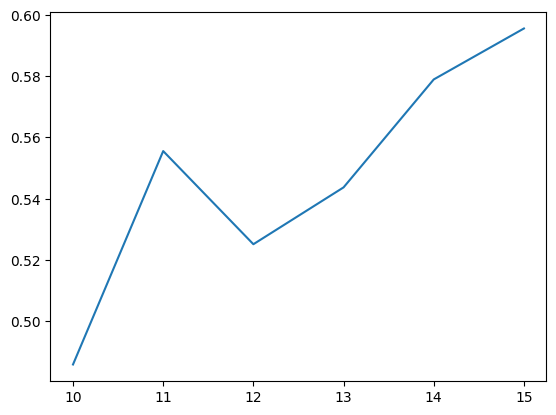

In [ ]:
plt.plot([10,11,12,13,14,15], coherence_values_topic)

In [ ]:
final_model = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=10,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.5,
                       iterations=70)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_words = [re.findall(r'"([^"]*)"',t[1]) for t in final_model.print_topics()]


final_topics = [' '.join(t[0:10]) for t in final_words]

for id, t in enumerate(final_topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
iamharaldur lol friend question great people way shellenbergermd good thinking

------ Topic 1 ------
bbc wallstreetsilv actually influence trungtphan yes think case fund need

------ Topic 2 ------
talent jonerlichman right heavy paulg industry cbdoge old 10 fix

------ Topic 3 ------
think probably scottadamssays drug time good legacy micsolana crime greatly

------ Topic 4 ------
amp day davidmweissman year timsweeneyepic teslaownerssv principle titterdaily check legacy

------ Topic 5 ------
yeah tesla people know right press actually davidasinclair try sf

------ Topic 6 ------
good help let platform titterdaily kanekoathegreat tell friend propaganda criminal

------ Topic 7 ------
therabbithole84 dogeofficialceo thinking pay long micsolana right trungtphan iamharaldur lol

------ Topic 8 ------
true twitter year ago actually scottadamssays buy davidmweissman 10 medium

------ Topic 9 ------
amp w launch rt wrong tell billym2k problem remove sf



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_perplexity = final_model.log_perplexity(corpus)
print('\nPerplexity: ', final_perplexity) 

final_coherence_model = CoherenceModel(model=final_model, texts=tweets_df['final_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_final = final_coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_final)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -5.697837825562185

Coherence Score:  0.5292507590703907


In [ ]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(final_model, corpus, id2word)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.106937  0.015167       1        1  16.965980
1     -0.053677 -0.221501       2        1  13.118160
4     -0.149146  0.069362       3        1  12.145060
8     -0.089572 -0.057599       4        1  11.914601
3      0.152725  0.038128       5        1   9.756864
6      0.127485  0.003126       6        1   9.256536
9     -0.027388  0.019354       7        1   9.074430
2     -0.108133  0.121512       8        1   8.704397
0      0.044594 -0.017141       9        1   4.941456
7     -0.003825  0.029592      10        1   4.122516, topic_info=                Term      Freq     Total Category  logprob  loglift
24       iamharaldur  2.000000  2.000000  Default  30.0000  30.0000
27              good  5.000000  5.000000  Default  29.0000  29.0000
90   therabbithole84  2.000000  2.000000  Default  28.0000  28.0000
1              right  5.000000  5.000000  Default  27.0000  27.0000
102           talent  2.000000  2.000000  Default  26.0000  26.0000
..               ...       ...       ...      ...      ...      ...
47             think  0.058689  5.301867  Topic10  -5.3132  -1.3149
57          probably  0.058689  2.930590  Topic10  -5.3132  -0.7220
61    davidmweissman  0.058689  3.766931  Topic10  -5.3132  -0.9731
64      jonerlichman  0.058689  2.907160  Topic10  -5.3132  -0.7140
66           company  0.058689  2.291360  Topic10  -5.3132  -0.4759

[411 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        3  0.341027       10
59        4  0.341027       10
59        8  0.341027       10
85        3  0.455259  account
85        6  0.455259  account
...     ...       ...      ...
5         1  0.767229     yeah
5         3  0.255743     yeah
63        3  0.537984     year
63        4  0.537984     year
38        2  0.898239      yes

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 9, 4, 7, 10, 3, 1, 8])

### Dominant Topic per Tweet

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=final_model, corpus=corpus, tweets=tweets_df['original_tweet'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tweet']

# Show
df_dominant_topic

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-2bc4fb0735af>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-51-2bc4fb0735af>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-51-2bc4fb0735af>:13: FutureWarning: The f

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tweet
0,0,7,0.7000,"therabbithole84, dogeofficialceo, thinking, pa...",@micsolana So inspiring to see that they have ...
1,1,0,0.1000,"iamharaldur, lol, friend, question, great, peo...",@ChrisJBakke 🤣
2,2,8,0.7750,"true, twitter, year, ago, actually, scottadams...",Final date for removing legacy Blue checks is ...
3,3,5,0.5500,"yeah, tesla, people, know, right, press, actua...",@MuskUniversity Yeah
4,4,5,0.9400,"yeah, tesla, people, know, right, press, actua...",@Liv_Boeree @micsolana It’s super easy to get ...
...,...,...,...,...,...
94,94,5,0.3667,"yeah, tesla, people, know, right, press, actua...","@BillyM2k Yeah, it’s weird"
95,95,2,0.8500,"talent, jonerlichman, right, heavy, paulg, ind...",@paulg Major misallocation of capital imo. Mos...
96,96,1,0.5500,"bbc, wallstreetsilv, actually, influence, trun...","@PeterDiamandis After AGI, yes"
97,97,2,0.5500,"talent, jonerlichman, right, heavy, paulg, ind...",@JonErlichman 🎯


### Most Relevant Tweet per Topic

In [ ]:
# Group top 5 sentences under each topic
most_relevant_tweet_df = pd.DataFrame()

most_relevant_tweet_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in most_relevant_tweet_grpd:
    most_relevant_tweet_df = pd.concat([most_relevant_tweet_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
most_relevant_tweet_df.reset_index(drop=True, inplace=True)

# Format
most_relevant_tweet_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Tweet"]

# Show
most_relevant_tweet_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Tweet
0,0,0.8500,"iamharaldur, lol, friend, question, great, peo...",@iamharaldur Great way to make friends lol
1,1,0.9357,"bbc, wallstreetsilv, actually, influence, trun...",@EndWokeness We need to add more granularity t...
2,2,0.8875,"talent, jonerlichman, right, heavy, paulg, ind...","@paulg Once prominent, they’re one of the few ..."
3,3,0.9250,"think, probably, scottadamssays, drug, time, g...",@micsolana I think we should legalize it. The ...
4,4,0.9308,"amp, day, davidmweissman, year, timsweeneyepic...",@davidmweissman @TitterDaily Too much corrupti...
5,5,0.9400,"yeah, tesla, people, know, right, press, actua...",@Liv_Boeree @micsolana It’s super easy to get ...
6,6,0.9000,"good, help, let, platform, titterdaily, kaneko...",@AnonOpsUnited I’m told Putin called me a war ...
7,7,0.7000,"therabbithole84, dogeofficialceo, thinking, pa...",@micsolana So inspiring to see that they have ...
8,8,0.9000,"true, twitter, year, ago, actually, scottadams...",@investmattallen @ShellenbergerMD @robbysoave ...
9,9,0.9000,"amp, w, launch, rt, wrong, tell, billym2k, pro...",Our landlord at SF HQ says we’re legally requi...
